## Softcosine Clusters

**Purpose:** cluster outlet articles based on softcosine similarity<br>
Code based on https://github.com/damian0604/newsevents/blob/master/src/analysis/clustering.ipynb

**Steps:**
1. merge pajek files into one file
2. define functions for transforming the files to a graph, partitioning the graph, analyzing it, etc.
3. conduct clustering
4. show clustering results, export clusters by similarity threshold to .jsonl

In [18]:
import os
from glob import glob
import json
from tqdm import tqdm
import leidenalg
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pprint import pprint
%matplotlib inline

In [2]:
nx.__version__

'2.4'

In [87]:
net_dir = os.path.join("..", "..", "data", "02-intermediate", "06-newsevents", "02-softcosine-pkl2net")
netmerged_dir = os.path.join("..", "..", "data", "02-intermediate", "06-newsevents", "03-softcosine-netmerged")
fig_dir = os.path.join("..", "..", "data", "02-intermediate", "06-newsevents", "04-softcosine-figures")
clusters_dir = os.path.join("..", "..", "data", "02-intermediate", "06-newsevents", "05-softcosine-clusters", "jsonl")

In [4]:
# matplotlib is logged even though disable_existing_loggers=yes in logging_config.yaml
# https://stackoverflow.com/a/51529172/7016397
# workaround is to manually set the level before creating my logger
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from usrightmedia.shared.loggers import get_logger
LOGGER = get_logger(filename = '03-softcosine-clustering', logger_type='main')

In [5]:
from inca import Inca
myinca=Inca()

In [6]:
from usrightmedia.shared.es_queries import query_by_ids

### merge pajek files into one file

Modified original code due to networkx version difference ([migration guide](https://networkx.org/documentation/stable/release/migration_guide_from_1.x_to_2.0.html)):

- `AttributeError: 'MultiGraph' object has no attribute 'node' -> use G.nodes` ([link](https://networkx.org/documentation/stable/release/release_2.4.html#deprecations))
- `AttributeError: 'Graph' object has no attribute 'selfloop_edges' -> nx.selfloop_edges(graph)` ([link](https://github.com/JiaxuanYou/P-GNN/issues/16#issuecomment-633232539))
>The Graph attributes G.node and G.edge have been removed in favor of using G.nodes[n] and G.edges[u, v]. Finally, the selfloop methods and add_path/star/cycle have been moved from graph methods to networkx functions.

In [7]:
softcosine_files = glob(f"{net_dir}/*.net")

In [8]:
def merge_pajek_files(files, output_file):
    G = nx.Graph()
    for f in tqdm(files):
        H = nx.read_pajek(f)
        for node in H:         # remove all node properties, such as misleading/non-unique ids
            del H.nodes[node]['id']
            del H.nodes[node]['x']
            del H.nodes[node]['y']
            del H.nodes[node]['shape']
        G.update(H)
    print(f'{len(G.nodes)} nodes and {len(G.edges)} edges')
    print('Removing self loops...')
    G.remove_edges_from(list(nx.selfloop_edges(G))) # self-loops are due to the 'source' and 'target' being the same doc during INCA's softcosine analysis 
    print(f'{len(G.nodes)} nodes and {len(G.edges)} edges')
    nx.write_pajek(G, output_file)
    print(f'All written to {output_file}')
    return G

Gnxsoft = merge_pajek_files(softcosine_files, os.path.join(netmerged_dir, 'softcosine_merged.net'))
Gsoft = ig.read(os.path.join(netmerged_dir, 'softcosine_merged.net'), format='pajek')

100%|██████████| 476/476 [02:58<00:00,  2.67it/s]


173348 nodes and 3044473 edges
Removing self loops...
173348 nodes and 2872645 edges
All written to ../../data/02-intermediate/06-newsevents/03-softcosine-netmerged/softcosine_merged.net


### 2. Define functions
Functions for transforming the files to a graph, partitioning the graph, analyzing it, etc.

In [9]:
def partition_graph(G0, minedgeweight):
    '''takes an igraph, prunes it and partitions it. returns a list of partitions '''
    G = G0.copy()
    G.es.select(weight_le=minedgeweight).delete()
    part = leidenalg.find_partition(G, leidenalg.SurpriseVertexPartition)
    print(part.summary())
    partitions = []
    for subgraph in part.subgraphs():
         partitions.append([node['id'] for node in subgraph.vs])
    return partitions

In [10]:
def show_descriptives(results, filename=None):
    '''takes a list of lists (articles per clusters), plots a histogram and prints descriptives'''
    articles_per_cluster = [len(x) for x in results]
    single_article_clusters = sum([1 if e==1 else 0 for e in articles_per_cluster])
    multiple_article_clusters = len(articles_per_cluster) - single_article_clusters
    fig = plt.figure(figsize=(10,5))
    plt.hist(articles_per_cluster, bins = max(articles_per_cluster), color='#5ab4ac', alpha=0.8, log=True)
    if filename:
        plt.savefig(filename+'.png', dpi=400)
        plt.savefig(filename+'.eps')
    plt.show()
    print(pd.Series(articles_per_cluster).describe())
    print(f'\nThere are {single_article_clusters} single-article clusters and {multiple_article_clusters} multiple-article clusters.')

In [81]:
def get_cluster_by_ids(ids, n_hits=10):
    '''Takes a list of IDs (associated with the same cluster) and retrieves the first n docs (n_hits) from ES.
       Returns a dict which includes three keys ('ids', 'total', 'docs')
           IDs and selected _source fields of the first n docs (n_hits) along with the total number of hits in ES.
    '''
    
    res = myinca.database._client.search(
        myinca.database._elastic_index,
        body=query_by_ids(ids=ids),
        _source=['title', 'publish_date'],
        sort='publish_date:asc',
        size=n_hits)
    
    res_dict = {}
    res_dict['cluster_size'] = res['hits']['total']
    hits = res['hits']['hits']
    
    for hit in hits:
        hit['_source']['_id'] = hit['_id']
    
    res_dict['docs'] = [hit['_source'] for hit in hits]

    return res_dict

In [84]:
def show_cluster_examples(results, n_clusters=1, n_hits=10):
    '''Prints cluster examples per softcosine threshold.
       It starts from the largest cluster (n_clusters=1).
       
       Args:
           results (list of lists): lists=clusters; each inner list is a set of IDs associated with the same cluster
           n_clusters (int): number of clusters to show
           n_hits (int): number of hits per cluster to show
           
    '''
    print('='*80)
    print(f"Showing {n_clusters} example cluster(s)...")
    print('-'*80)
    for n in range(0,n_clusters):
        cluster = get_cluster_by_ids(results[n], n_hits=n_hits)
        print(f"Example {n}: the cluster contains {cluster['cluster_size']} documents.")
        if len(cluster['docs']) == 1:
            print(f"Below is {len(cluster['docs'])} doc from the cluster.\n")
        else:
            print(f"Below are {len(cluster['docs'])} docs from the cluster.\n")
        print("Titles:\n")
        pprint([doc['title'] for doc in cluster['docs']])
        print("\nPublish dates:\n")
        pprint([doc['publish_date'] for doc in cluster['docs']])
        print("\nIDs:\n")
        pprint([doc['_id'] for doc in cluster['docs']])
        print(f"{'-'*80}\n")

In [77]:
def export_clusters_to_jsonl(results, similarity, minedgeweight):
    """For a given similarity-mindedgeweight combination, export the clustered docs to a .jsonl file.
    
    Args:
        results (list of lists): lists=clusters; each inner list is a set of IDs associated with the same cluster
        similarity (str): e.g.,'softcos'
        minedgeweight (int): e.g., 0.2
    
    """
    for n in range(0, len(results)):
        # 10,000 is ES search endpoint's size limit
        # if a cluster actually contains 10,000+ docs, it's probably more similar to a topic/theme than a specific news event
        cluster = get_cluster_by_ids(results[n], n_hits=10000)
    
        sim_weight = f"{similarity}{str(minedgeweight).replace('.', '')}"
        cluster['cluster_id'] = f"{sim_weight}_{n}"
        
        filename=f"clusters_{sim_weight}.jsonl"
        with open(file=os.path.join(clusters_dir, filename), mode="a", encoding="utf-8") as file:
            file.write(json.dumps(cluster) + "\n")
            
    print(f"Exported {len(results)} clusters to {filename}.")

In [82]:
def print_gridreport(gridresults, n_clusters=1, n_hits=10, export_clusters=True):
    for r in gridresults:
        l = r['results']
        flattened = [item for sublist in l for item in sublist]
        print(f"{r['similarity']}, threshold={r['minedgeweight']}: Found {len(flattened)} articles, out of which {len(set(flattened))} are unique articles")
    print('(hint: if *not* all articles are unique, then articles are assigned to multiple clusters)')
    print('\n')

    for r in gridresults:
        print("*"*80)
        similarity = r['similarity']
        minedgeweight = r['minedgeweight']
        fn = f"{similarity}{str(minedgeweight).replace('.','')}"
        results = r['results']
        print(f'Similarity metric: {similarity}\nMinimum edgeweight: {minedgeweight}\n')
        print("*"*80)
        show_descriptives(results, filename = f"{os.path.join(fig_dir, fn)}")
        show_cluster_examples(results, n_clusters=n_clusters, n_hits=n_hits)
        if export_clusters:
            export_clusters_to_jsonl(results, similarity, minedgeweight)
        print('\n\n')

### 3. Conduct clustering
Use a grid to vary the minimum edgeweight threshold (.2, .3, .4, .5, .6, .7, .8, .9)

In [42]:
grid = [('softcos', Gsoft, .2),
        ('softcos', Gsoft, .3),
        ('softcos', Gsoft, .4),
        ('softcos', Gsoft, .5),
        ('softcos', Gsoft, .6),
        ('softcos', Gsoft, .7),
        ('softcos', Gsoft, .8),
        ('softcos', Gsoft, .9)]

gridresults = [{'similarity':similarity, 'minedgeweight': minedgeweight, 'results': partition_graph(G, minedgeweight)} 
              for similarity, G, minedgeweight in tqdm(grid)]

  0%|          | 0/8 [00:00<?, ?it/s]

Clustering with 173348 elements and 34837 clusters


 12%|█▎        | 1/8 [00:11<01:18, 11.28s/it]

Clustering with 173348 elements and 65207 clusters


 25%|██▌       | 2/8 [00:22<01:08, 11.39s/it]

Clustering with 173348 elements and 92873 clusters


 38%|███▊      | 3/8 [00:34<00:57, 11.58s/it]

Clustering with 173348 elements and 117839 clusters


 50%|█████     | 4/8 [00:48<00:50, 12.70s/it]

Clustering with 173348 elements and 140838 clusters


 62%|██████▎   | 5/8 [01:05<00:42, 14.25s/it]

Clustering with 173348 elements and 159055 clusters


 75%|███████▌  | 6/8 [01:23<00:30, 15.27s/it]

Clustering with 173348 elements and 168922 clusters


 88%|████████▊ | 7/8 [01:40<00:15, 15.89s/it]

Clustering with 173348 elements and 171953 clusters


100%|██████████| 8/8 [01:57<00:00, 14.74s/it]


### 4. Print clustering results and export clusters

softcos, threshold=0.2: Found 173348 articles, out of which 173348 are unique articles
softcos, threshold=0.3: Found 173348 articles, out of which 173348 are unique articles
softcos, threshold=0.4: Found 173348 articles, out of which 173348 are unique articles
softcos, threshold=0.5: Found 173348 articles, out of which 173348 are unique articles
softcos, threshold=0.6: Found 173348 articles, out of which 173348 are unique articles
softcos, threshold=0.7: Found 173348 articles, out of which 173348 are unique articles
softcos, threshold=0.8: Found 173348 articles, out of which 173348 are unique articles
softcos, threshold=0.9: Found 173348 articles, out of which 173348 are unique articles
(hint: if *not* all articles are unique, then articles are assigned to multiple clusters)


********************************************************************************
Similarity metric: softcos
Minimum edgeweight: 0.2

*******************************************************************************

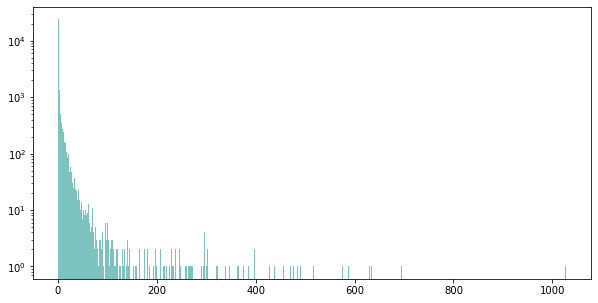

count    34837.000000
mean         4.975974
std         24.287206
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1027.000000
dtype: float64

There are 23953 single-article clusters and 10884 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 1027 documents.
Below are 5 docs from the cluster.

Titles:

["Pompeo: US will hold Iran 'accountable' for any 'malign activity,' after "
 'Baghdad embassy attack',
 "Elizabeth Warren Blames Unrest on Trump's 'Reckless' Decision to Ditch Iran "
 'Deal',
 'Rebecca Grant: Iranian-backed attack on American Embassy in Iraq increases '
 'risk of US-Iran military conflict',
 'Protesters burn security post at U.S. Embassy in Iraq in new foreign policy '
 'test for Trump',
 'Pentagon: U.S. to Deploy 750 Troops After Embassy Attack in Iraq']

Publish dates:

['2020-01-01T00:07:04+00:00',


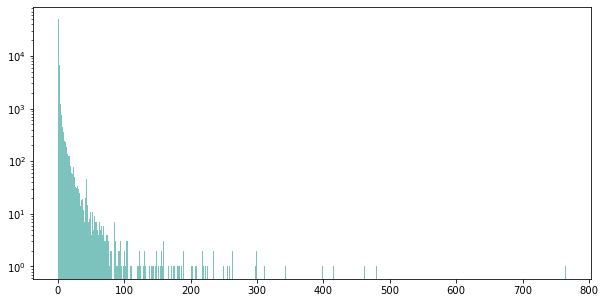

count    65207.000000
mean         2.658426
std         10.392614
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        765.000000
dtype: float64

There are 49644 single-article clusters and 15563 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 765 documents.
Below are 5 docs from the cluster.

Titles:

["Pompeo: US will hold Iran 'accountable' for any 'malign activity,' after "
 'Baghdad embassy attack',
 "Elizabeth Warren Blames Unrest on Trump's 'Reckless' Decision to Ditch Iran "
 'Deal',
 'Rebecca Grant: Iranian-backed attack on American Embassy in Iraq increases '
 'risk of US-Iran military conflict',
 'Protesters burn security post at U.S. Embassy in Iraq in new foreign policy '
 'test for Trump',
 'Pentagon: U.S. to Deploy 750 Troops After Embassy Attack in Iraq']

Publish dates:

['2020-01-01T00:07:04+00:00',
 

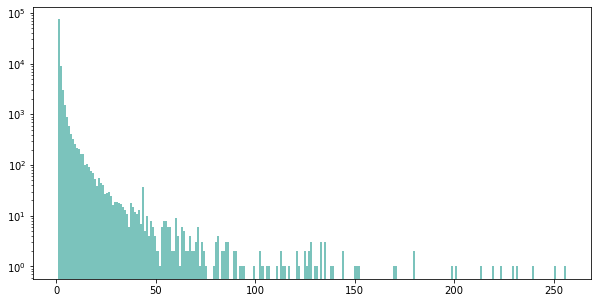

count    92873.000000
mean         1.866506
std          5.211756
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        256.000000
dtype: float64

There are 74810 single-article clusters and 18063 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 256 documents.
Below are 5 docs from the cluster.

Titles:

["Joe Biden baffles with promise to appoint 'first African-American woman' to "
 'Senate',
 "Van Jones: Biden's campaign has been 'dead man walking for a long time'",
 "Trump holds rally in North Charleston on eve of Dems' South Carolina primary",
 "Laura Ingraham: Joe Biden's 'lagging campaign' lacks 'the Obama magic' -- "
 'and money',
 "Larry Elder: 2020 Republicans are ready to party like it's 1972"]

Publish dates:

['2020-02-28T19:41:27+00:00',
 '2020-02-28T20:10:27+00:00',
 '2020-02-29T00:09:13+00:00',
 '2020-02-2

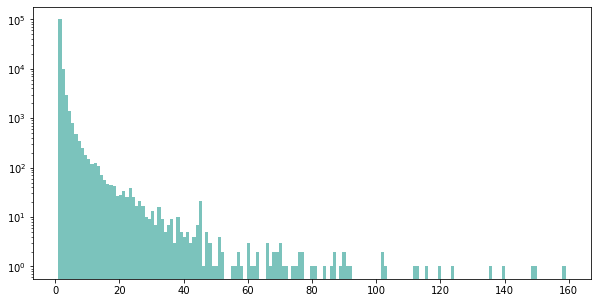

count    117839.000000
mean          1.471058
std           2.816543
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         159.000000
dtype: float64

There are 100295 single-article clusters and 17544 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 159 documents.
Below are 5 docs from the cluster.

Titles:

['Trump reportedly called for release of FISA abuses memo, which DOJ says '
 "would be 'reckless' without review",
 'Byron York: House Intel meets Monday and could vote on memo release — is '
 'Jeff Sessions softening his stance?',
 'FISA Firestorm: Sean Hannity Gives MAJOR Clue About &#8220;TICK TOCK&#8221; '
 'Set To Drop TOMORROW',
 "Devin Nunes memo shows Trump's Justice Department extended Carter Page "
 'surveillance: Report',
 'Here’s Trump’s Next Move On The Memo [VIDEO]']

Publish dates:

['2018-01-28T0

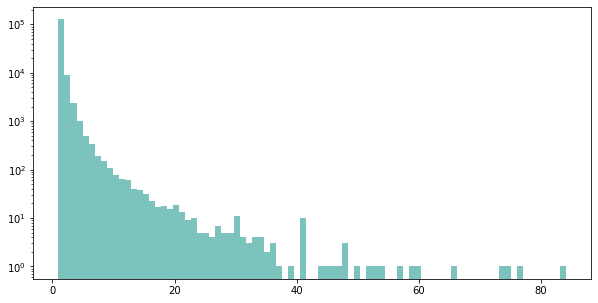

count    140838.000000
mean          1.230833
std           1.379654
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          84.000000
dtype: float64

There are 126550 single-article clusters and 14288 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 84 documents.
Below are 5 docs from the cluster.

Titles:

["Virginia governor's yearbook page features photo of men in KKK robe, "
 'blackface',
 'Northam Apologizes For Yearbook Photo Of Blackface And KKK Robes',
 'Virginia GOP calls on Democratic governor to resign over black face, KKK '
 'yearbook photo',
 'Ralph Northam ‘deeply sorry’ for racist photo, dodges whether he wore '
 'blackface or KKK costume',
 'Petition to Remove Gov. Northam Gathers Steam After Medical School Yearbook '
 'Page Shows Men in Blackface, KKK Robe']

Publish dates:

['2019-02-01T05:00:00+00

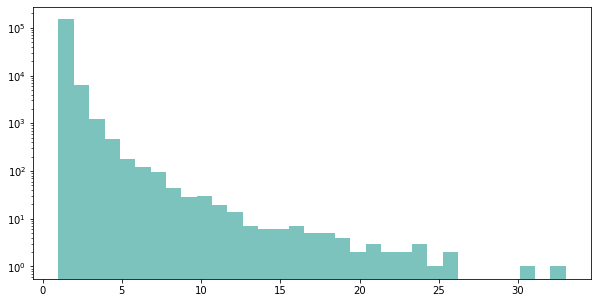

count    159055.000000
mean          1.089862
std           0.568553
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          33.000000
dtype: float64

There are 150342 single-article clusters and 8713 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 33 documents.
Below are 5 docs from the cluster.

Titles:

['‘Unbelievable’: FBI Agents’ Missing Text Messages Compared To Lois Lerner '
 'Email Scandal',
 'FBI Agents Spoke Of ‘Pressure’ To Wrap Up Clinton Probe As Trump Surged To '
 'GOP Nomination',
 'FBI ‘Failed To Preserve’ Five Months Of Text Messages Between Anti-Trump FBI '
 'Agents',
 'CONFUSION: FBI Claims Five Months Of Strzok-Page Texts Missing &#8212; Yet '
 'DOJ IG Says He Received the Same Missing Texts In August',
 'Whoops! FBI ‘Loses’ Five Months of Texts Between FBI Agents Peter Strzok and '
 'Lisa Page'

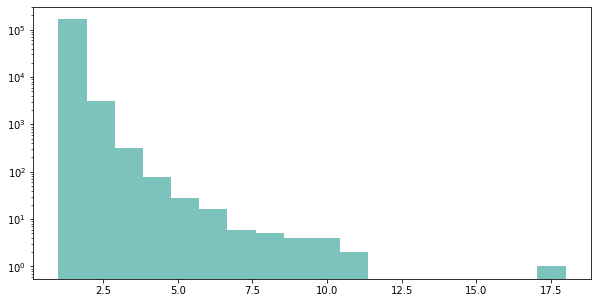

count    168922.000000
mean          1.026201
std           0.209839
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          18.000000
dtype: float64

There are 165278 single-article clusters and 3644 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 18 documents.
Below are 5 docs from the cluster.

Titles:

['Netanyahu skips AIPAC after Gaza rocket hits Israeli home, injuring 7',
 'Netanyahu to cut U.S. visit short after seven wounded in rocket attack near '
 'Tel Aviv',
 'Netanyahu to Cut Short Washington Visit After Terror Rocket Strike Near Tel '
 'Aviv',
 'Netanyahu Cuts Short US Visit Over Gaza Tensions ',
 "Netanyahu Vows to 'Respond Forcefully' After Terror Rocket Injures 7 "
 'Israelis']

Publish dates:

['2019-03-25T04:00:00+00:00',
 '2019-03-25T07:56:12+00:00',
 '2019-03-25T10:32:04+00:00',
 '2019-03-25T11:

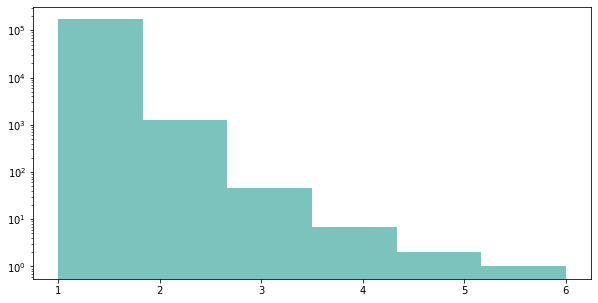

count    171953.000000
mean          1.008113
std           0.095300
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
dtype: float64

There are 170628 single-article clusters and 1325 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 6 documents.
Below are 5 docs from the cluster.

Titles:

["Full text of President Donald Trump's inauguration speech | Fox News",
 "Transcript of Donald Trump's Inaugural Address | Newsmax.com",
 'Complete Text of President Donald Trump’s Inaugural Address',
 'Donald Trump Inaugural Address: Video Clips, Quotes, Highlights',
 '‘America First’: President Donald Trump Brings the Rain in Inauguration '
 'Address']

Publish dates:

['2017-01-20T05:00:00+00:00',
 '2017-01-20T05:00:00+00:00',
 '2017-01-20T17:52:32+00:00',
 '2017-01-20T19:06:12+00:00',
 '2017-01-20T19:48:59+00:

In [86]:
print_gridreport(gridresults, n_clusters=3, n_hits=5, export_clusters=True)